# **Projet 8 : Réalisez un dashboard et assurez une veille technique**

L’objectif de cette partie est de réaliser un **état de l’art sur une technique récente de modélisation de données textuelles**, publiée depuis moins de cinq ans, afin d’évaluer son **apport par rapport à une méthode plus classique** déjà mise en œuvre dans un projet précédent (Projet 6).

Dans ce cadre, nous avons choisi d’étudier **INSTRUCTOR** (*Instruction-Finetuned Text Embeddings*), une approche récente permettant de produire des **embeddings sémantiques orientés par une instruction de tâche**, et de la comparer à une méthode plus classique basée sur **Sentence-BERT (SBERT)**.

Cette veille technique vise à :
- approfondir la compréhension des méthodes récentes d’embeddings de texte,
- évaluer leur pertinence opérationnelle dans un cadre industriel,
- mesurer leur apport sur un cas d’usage réel déjà connu : la **classification d’articles e-commerce** issue du Projet 6.

# 📚 Sommaire

0. Import des librairies et fonctions utilitaires  
1. Présentation et exploration du jeu de données  
2. Préparation et nettoyage des textes  
3. Analyse descriptive des catégories  
4. Séparation Train / Validation / Test
5. Baseline : SBERT (Sentence-BERT – MiniLM)  
6. Veille technique : INSTRUCTOR (Instruction-based embeddings)  
7. Comparaison des performances  
8. Discussion des résultats, limites et perspectives  
9. Conclusion

### **0. Import des librairies et fonctions utilitaires** 

Cette section regroupe :
- les librairies standards de manipulation de données,
- les outils NLP classiques (NLTK),
- les modèles d’embeddings,
- ainsi que des fonctions utilitaires utilisées pour la visualisation et l’analyse exploratoire (réduction de dimension, t-SNE, clustering).

Certaines fonctions sont héritées des expérimentations menées dans le Projet 6 et sont conservées ici à des fins de continuité méthodologique.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import Counter

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

import missingno as msno
from sentence_transformers import SentenceTransformer
from time import perf_counter
import torch

c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def minimal_clean(text: str) -> str:
    text = text.lower()
    text = text.replace("\n", " ").replace("\t", " ")
    text = " ".join(text.split())  # supprime espaces multiples
    return text

In [5]:
# Réduction générique (PCA si dense, TruncatedSVD si sparse)
def reduce_dimensionality(X, n_components=50, random_state=42, scale_after=True):
    """
    Réduction de dimension :
    - TruncatedSVD si matrice sparse
    - PCA si matrice dense
    """
    n_components = max(
        2,
        min(n_components, X.shape[1] - 1 if X.shape[1] > 1 else 1)
    )

    if sparse.issparse(X):
        X_red = TruncatedSVD(
            n_components=n_components,
            random_state=random_state
        ).fit_transform(X)

        if scale_after:
            X_red = StandardScaler().fit_transform(X_red)

        return X_red

    else:
        X_scaled = StandardScaler().fit_transform(np.asarray(X))
        return PCA(
            n_components=n_components,
            random_state=random_state
        ).fit_transform(X_scaled)

In [6]:
# t-SNE pour la visualisation (sur l’espace réduit) : calcule une projection 2D non linéaire
def tsne_embed(X_red, perplexity=30, random_state=42, metric="euclidean"):
    """
    Projection t-SNE en 2D
    """
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        metric=metric,
        random_state=random_state
    )
    return tsne.fit_transform(X_red)


In [7]:
# KMeans (sur t-SNE)
def kmeans_on_tsne(X_tsne, k, n_init=50, random_state=42):
    return KMeans(
        n_clusters=k,
        n_init=n_init,
        random_state=random_state
    ).fit_predict(X_tsne)


In [8]:
def align_clusters_hungarian(df):
    """
    Aligne les clusters KMeans avec les catégories réelles (1–1)
    via l'algorithme hongrois.
    """
    contingency = pd.crosstab(df["cluster"], df["category"])
    row_ind, col_ind = linear_sum_assignment(-contingency.values)

    cluster_to_cat = {
        contingency.index[r]: contingency.columns[c]
        for r, c in zip(row_ind, col_ind)
    }

    df["cluster_label"] = df["cluster"].map(
        lambda x: f"{x} → {cluster_to_cat.get(x, '?')}"
    )

    return df, cluster_to_cat

In [9]:
CATEGORY_COLORS = {
    "Home Furnishing": "#1f77b4",          # bleu
    "Baby Care": "#ff7f0e",                # orange
    "Watches": "#2ca02c",                  # vert
    "Home Decor & Festive Needs": "#d62728",# rouge
    "Kitchen & Dining": "#9467bd",         # violet
    "Beauty and Personal Care": "#8c564b", # marron
    "Computers": "#e377c2",                # rose
}


In [10]:
def plot_tsne_side_by_side(df, cluster_palette, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

    # Catégories réelles
    sns.scatterplot(
        data=df,
        x="x", y="y",
        hue="category",
        palette=CATEGORY_COLORS,
        s=50,
        ax=axes[0]
    )
    axes[0].set_title(f"Catégories réelles {title}")
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    # Clusters alignés
    sns.scatterplot(
    data=df,
    x="x", y="y",
    hue="cluster",              
    palette=cluster_palette,
    s=50,
    ax=axes[1]
)
    axes[1].set_title(f"Clusters KMeans {title}")
    axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


In [11]:
def run_pipeline(
    X, y_true, k=None,
    n_components=50, perplexity=30, random_state=42,
    n_init=50, show_plot=True, title=""
):
    """
    - Réduction (PCA/SVD) -> t-SNE
    - KMeans SUR le t-SNE
    - Alignement clusters ↔ catégories (algorithme hongrois)
    - Visualisation côte à côte
    """
    t0 = perf_counter()

    y_true = np.asarray(y_true).astype(str)
    if k is None:
        k = len(np.unique(y_true))

    # 1. Réduction + t-SNE
    X_red  = reduce_dimensionality(X, n_components=n_components, random_state=random_state)
    X_tsne = tsne_embed(X_red, perplexity=perplexity, random_state=random_state)

    # 2. Clustering
    y_pred = kmeans_on_tsne(X_tsne, k=k, n_init=n_init, random_state=random_state)

    # 3. Scores
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)

    # 4. DataFrame visu
    df_visu = pd.DataFrame({
        "x": X_tsne[:, 0],
        "y": X_tsne[:, 1],
        "category": y_true,
        "cluster": y_pred
    })

    # 🔑 5. ALIGNEMENT HONGROIS (OBLIGATOIRE)
    df_visu, cluster_to_cat = align_clusters_hungarian(df_visu)
    df_visu["color"] = df_visu["category"].map(CATEGORY_COLORS)
    # palette cluster -> couleur catégorie alignée
    cluster_palette = {
        cluster: CATEGORY_COLORS[cat]
        for cluster, cat in cluster_to_cat.items()
    }


    # 6. Plot
    if show_plot:
        plot_tsne_side_by_side(df_visu, cluster_palette=cluster_palette, title=title)

    time_total_s = perf_counter() - t0

    return {
        "ari": ari,
        "nmi": nmi,
        "homogeneity": h,
        "completeness": c,
        "v_measure": v,
        "X_tsne": X_tsne,
        "y_pred": y_pred,
        "df_visu": df_visu,
        "cluster_to_cat": cluster_to_cat,
        "time_total_s": time_total_s
    }


In [12]:
def encode_llm_mean_pooling(
    texts,
    tokenizer,
    model,
    batch_size=16,
    max_length=256
):
    """
    Encode des textes via un Transformer généraliste
    + mean pooling (LLM2Vec-like)
    """
    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]

            encoded = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            outputs = model(**encoded)

            last_hidden = outputs.last_hidden_state      # (B, T, H)
            attention_mask = encoded["attention_mask"]  # (B, T)

            # Mean pooling masqué
            mask = attention_mask.unsqueeze(-1)
            pooled = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1)

            embeddings.append(pooled.cpu().numpy())

    return np.vstack(embeddings)


In [13]:
def embed_openai(texts, model="text-embedding-3-large", batch_size=100):
    """
    Génère des embeddings OpenAI pour une liste de textes.
    Retourne un array numpy (n_samples, embedding_dim)
    """
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        response = client.embeddings.create(
            model=model,
            input=batch
        )

        batch_embeddings = [item.embedding for item in response.data]
        embeddings.extend(batch_embeddings)

    return np.array(embeddings)


### **1. Présentation et exploration du jeu de données** 

Les données utilisées dans ce projet sont issues du **Projet 6**, portant sur la classification de produits e-commerce (Flipkart).
Elles contiennent notamment :
- la description textuelle des articles,
- leur catégorie hiérarchique,
- et des informations annexes non exploitées dans cette étude.

L’objectif est de conserver un **cas d’usage identique** afin de comparer uniquement l’impact du changement de méthode d’embedding.

In [14]:
data = pd.read_csv(
    "C:/Users/marga/Documents/Openclassrooms/_Projet_6/Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv"
)

data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [15]:
print("Nombre de lignes :", data.shape[0])
print("Nombre de colonnes :", data.shape[1])

Nombre de lignes : 1050
Nombre de colonnes : 15


uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64


<Axes: >

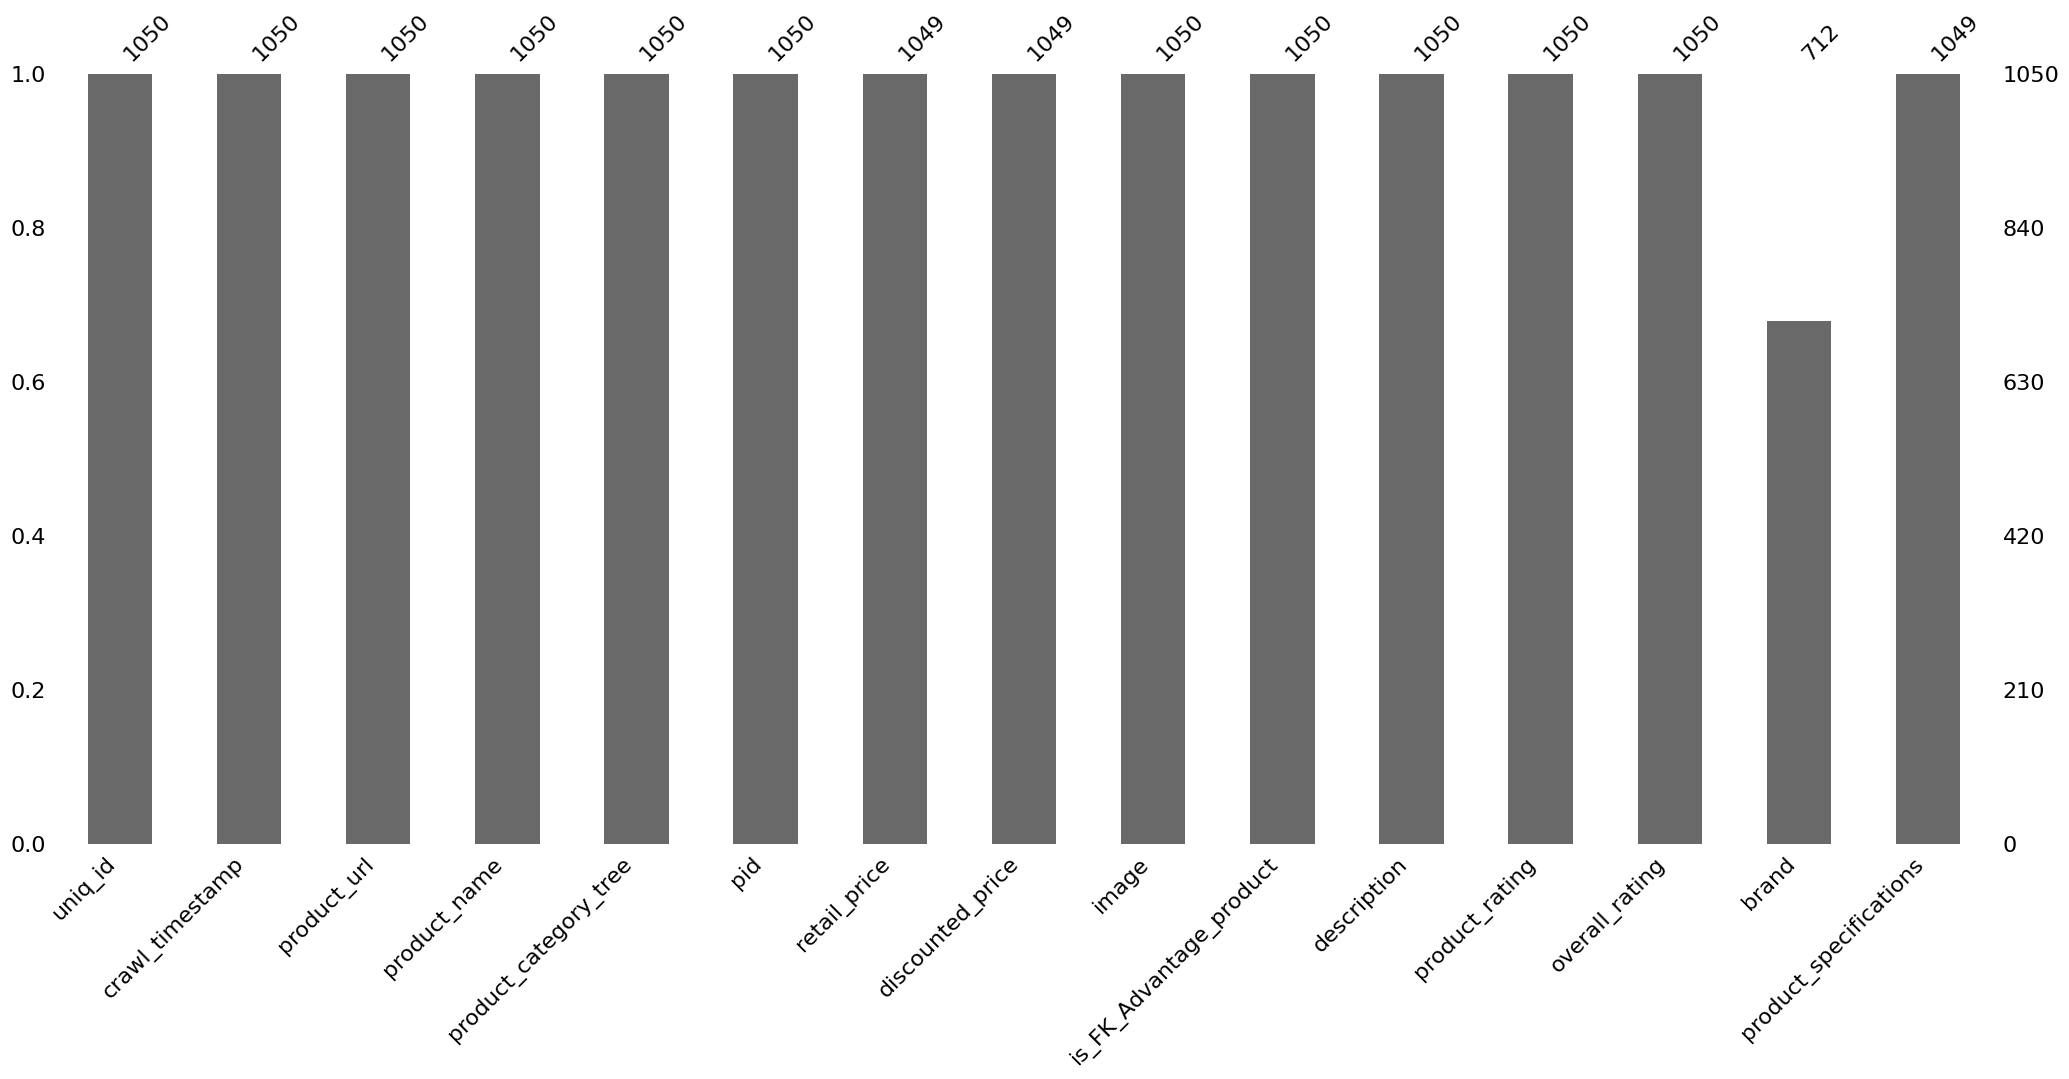

In [16]:
# Valeurs manquantes 
print(data.isna().sum())
msno.bar(data)

In [17]:
total_missing = data.isnull().sum().sum()
taux_remplissage = 1 - total_missing / data.size
print(f"Taux de remplissage : {taux_remplissage*100:.2f}%")

Taux de remplissage : 97.83%


In [18]:
print("Nombre de doublons :", data.duplicated().sum())

Nombre de doublons : 0


In [19]:
# On recrée la catégorie principale
data["main_category"] = (
    data["product_category_tree"]
    .astype(str)
    .apply(lambda x: x.split(">>")[0].strip('[" '))
)

data["main_category"].value_counts()


main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

### **2. Préparation et nettoyage des textes** 

La préparation des textes suit une approche classique en NLP :
- normalisation (minuscule),
- suppression des mots très fréquents et non informatifs,
- lemmatisation.

Cette étape permet de réduire le bruit tout en conservant l’information sémantique utile à la classification.


- Minuscule

In [20]:
data["description_clean"] = data["description"].astype(str).str.lower()

- Tokenisation

In [21]:
data["tokens"] = data["description_clean"].apply(word_tokenize)


- Stopwords personnalisés

In [22]:
freq = Counter()
for tokens in data["tokens"]:
    freq.update(tokens)

top_100 = set([w for w, _ in freq.most_common(100)])
stopwords_nltk = set(stopwords.words("english"))

stopwords_final = top_100.union(stopwords_nltk)


- Nettoyage des tokens

In [23]:
data["tokens_clean"] = data["tokens"].apply(
    lambda tokens: [
        w for w in tokens
        if w not in stopwords_final
        and w.isalpha()
        and len(w) > 2
    ]
)


- Lemmatisation

In [24]:
lemmatizer = WordNetLemmatizer()

data["tokens_lemmatized"] = data["tokens_clean"].apply(
    lambda tokens: [lemmatizer.lemmatize(w) for w in tokens]
)


- Reconstruction du texte final

In [25]:
data["text_final"] = data["tokens_lemmatized"].apply(lambda x: " ".join(x))
data[["text_final", "main_category"]].head()


,text_final,main_category
0,elegance polyester abstract eyelet door curtai...,Home Furnishing
1,sathiyas bath towel bath towel red yellow blue...,Baby Care
2,eurospa terry face towel small height gsm euro...,Baby Care
3,santosh royal fashion printed king sized doubl...,Home Furnishing
4,jaipur print floral king sized double bedsheet...,Home Furnishing


### **3. Analyse descriptive des catégories** 

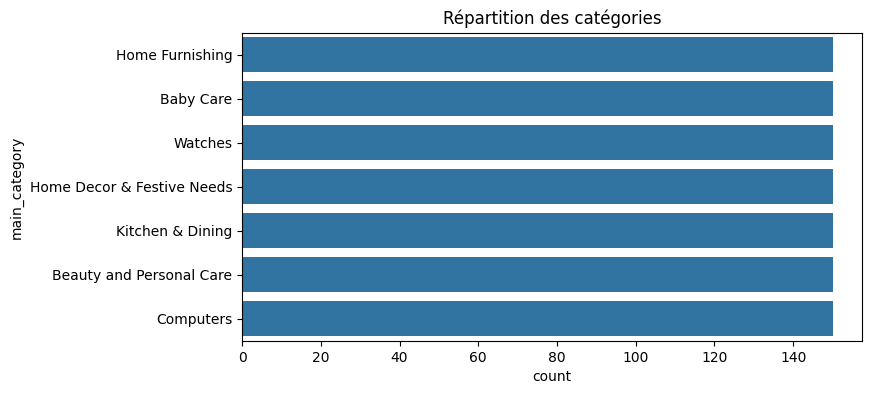

In [43]:
plt.figure(figsize=(8,4))
sns.countplot(y=data["main_category"], order=data["main_category"].value_counts().index)
plt.title("Répartition des catégories")
plt.show()

### **4. Séparation Train / Validation / Test**

In [26]:
X = data["text_final"]
y = data["main_category"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)


In [27]:
print("Train :", X_train.shape[0])
print("Validation :", X_val.shape[0])
print("Test :", X_test.shape[0])


Train : 735
Validation : 157
Test : 158


### **5. Baseline : SBERT (Sentence-BERT – MiniLM)**

SBERT est utilisé comme **méthode de référence**, car il avait déjà été employé avec succès dans le Projet 6.
Le modèle `all-MiniLM-L6-v2` repose sur une architecture légère (MiniLM) entraînée pour produire des embeddings de phrases optimisés pour la similarité sémantique.

Le classifieur choisi est une **régression logistique**, volontairement simple, afin de comparer uniquement la qualité des représentations vectorielles.

In [28]:
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [29]:
X_train_sbert = sbert_model.encode(X_train.tolist(), show_progress_bar=True)
X_val_sbert   = sbert_model.encode(X_val.tolist(), show_progress_bar=True)
X_test_sbert  = sbert_model.encode(X_test.tolist(), show_progress_bar=True)

Batches: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


In [30]:
clf_sbert = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

clf_sbert.fit(X_train_sbert, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [31]:
y_test_pred_sbert = clf_sbert.predict(X_test_sbert)

print("=== SBERT ===")
print(classification_report(y_test, y_test_pred_sbert))

=== SBERT ===
                            precision    recall  f1-score   support

                 Baby Care       0.83      0.91      0.87        22
  Beauty and Personal Care       1.00      0.95      0.98        22
                 Computers       0.88      1.00      0.94        23
Home Decor & Festive Needs       0.91      0.87      0.89        23
           Home Furnishing       0.91      0.91      0.91        23
          Kitchen & Dining       1.00      0.95      0.98        22
                   Watches       1.00      0.91      0.95        23

                  accuracy                           0.93       158
                 macro avg       0.93      0.93      0.93       158
              weighted avg       0.93      0.93      0.93       158



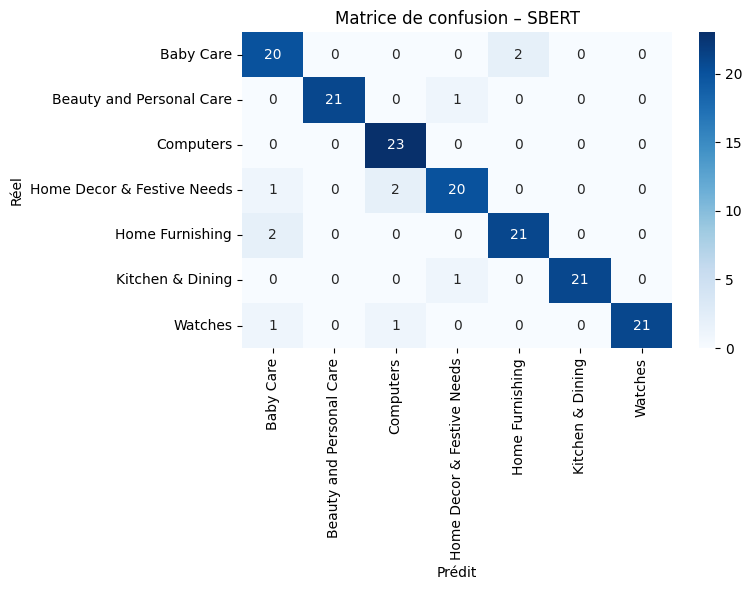

In [32]:
cm_sbert = confusion_matrix(y_test, y_test_pred_sbert, labels=clf_sbert.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_sbert,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=clf_sbert.classes_,
    yticklabels=clf_sbert.classes_
)
plt.title("Matrice de confusion – SBERT")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


### **6. Veille technique : INSTRUCTOR (Instruction-based embeddings)**

*Su et al., 2022 – One Embedder, Any Task: Instruction-Finetuned Text Embeddings*

https://arxiv.org/abs/2212.09741    |    https://instructor-embedding.github.io/

INSTRUCTOR est un modèle d’embeddings entraîné à intégrer explicitement une **instruction de tâche** lors de l’encodage des textes.
Contrairement aux approches classiques où le texte est encodé de manière générique, INSTRUCTOR produit des représentations **orientées par l’objectif final** (classification, recherche d’information, similarité, etc.).

Dans cette étude, l’instruction utilisée est la suivante :

> *"Represent the product description for product category classification"*

Cette formulation permet d’orienter l’espace vectoriel vers la tâche de classification, sans nécessiter de fine-tuning supervisé.


In [ ]:
print(torch.__version__)

2.9.1+cpu


In [33]:
instructor_model = SentenceTransformer("hkunlp/instructor-base")

c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\marga\.cache\huggingface\hub\models--hkunlp--instructor-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fallin

In [34]:
test_emb = instructor_model.encode(
    [["Represent the document for classification", "Test de chargement"]],
    normalize_embeddings=True
)

print(test_emb.shape)


(1, 768)


In [35]:
INSTRUCTION = "Represent the product description for product category classification"

In [36]:
X_train_instr = instructor_model.encode(
    [[INSTRUCTION, t] for t in X_train],
    normalize_embeddings=True,
    show_progress_bar=True
)

Batches: 100%|██████████| 23/23 [00:46<00:00,  2.01s/it]


In [37]:
X_val_instr = instructor_model.encode(
    [[INSTRUCTION, t] for t in X_val],
    normalize_embeddings=True,
    show_progress_bar=True
)

X_test_instr = instructor_model.encode(
    [[INSTRUCTION, t] for t in X_test],
    normalize_embeddings=True,
    show_progress_bar=True
)

Batches: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


In [38]:
clf_sbert = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

clf_instr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

clf_sbert.fit(X_train_sbert, y_train)
clf_instr.fit(X_train_instr, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [39]:
y_test_pred_instr = clf_instr.predict(X_test_instr)

print("=== INSTRUCTOR ===")
print(classification_report(y_test, y_test_pred_instr))

=== INSTRUCTOR ===
                            precision    recall  f1-score   support

                 Baby Care       0.90      0.86      0.88        22
  Beauty and Personal Care       0.95      0.82      0.88        22
                 Computers       0.79      1.00      0.88        23
Home Decor & Festive Needs       0.82      0.78      0.80        23
           Home Furnishing       0.85      0.96      0.90        23
          Kitchen & Dining       1.00      0.86      0.93        22
                   Watches       1.00      0.96      0.98        23

                  accuracy                           0.89       158
                 macro avg       0.90      0.89      0.89       158
              weighted avg       0.90      0.89      0.89       158



In [40]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

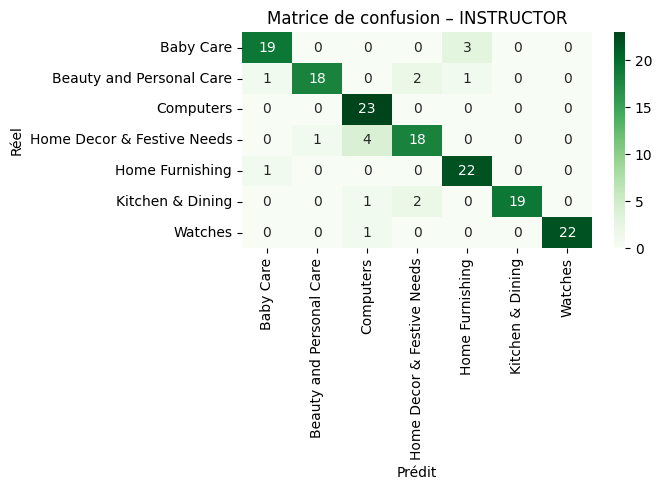

In [41]:
plot_confusion_matrix(
    y_test,
    y_test_pred_instr,
    clf_instr.classes_,
    "Matrice de confusion – INSTRUCTOR"
)

### **7. Comparaison des performances**

Sur ce jeu de données, la baseline SBERT obtient de meilleures performances que le modèle INSTRUCTOR.
Ce résultat peut s’expliquer par :
- la nature homogène du corpus,
- la clarté des catégories,
- et le fait que la tâche est unique et bien définie.

Dans ce contexte, des embeddings génériques bien entraînés suffisent à obtenir de très bonnes performances.
L’intérêt d’INSTRUCTOR réside davantage dans des contextes multi-tâches, multi-domaines ou faiblement supervisés.

In [42]:
results = pd.DataFrame({
    "Modèle": ["SBERT (MiniLM)", "INSTRUCTOR"],
    "Precision (macro)": [
        precision_score(y_test, y_test_pred_sbert, average="macro"),
        precision_score(y_test, y_test_pred_instr, average="macro")
    ],
    "Recall (macro)": [
        recall_score(y_test, y_test_pred_sbert, average="macro"),
        recall_score(y_test, y_test_pred_instr, average="macro")
    ],
    "F1-score (macro)": [
        f1_score(y_test, y_test_pred_sbert, average="macro"),
        f1_score(y_test, y_test_pred_instr, average="macro")
    ]
})

results

,Modèle,Precision (macro),Recall (macro),F1-score (macro)
0,SBERT (MiniLM),0.934298,0.930548,0.931187
1,INSTRUCTOR,0.901367,0.891587,0.892707


### **8. Discussion des résultats, limites et perspectives**

- INSTRUCTOR est utilisé ici sans fine-tuning spécifique.
- Des performances supérieures pourraient être obtenues dans un cadre multi-domaines.
- L’utilisation d’instructions alternatives ou plus détaillées pourrait également être explorée.
- Une extension naturelle consisterait à combiner texte et image, comme dans le Projet 6, via des approches multimodales.

### **9. Conclusion**

Cette veille technique montre que les modèles d’embeddings orientés par instruction, comme INSTRUCTOR, constituent une approche récente et prometteuse.
Toutefois, sur un corpus homogène et bien structuré, une méthode plus classique comme SBERT reste une solution très performante.

Le choix de la méthode d’embedding doit donc être guidé par la complexité du problème, la diversité des tâches et les contraintes opérationnelles.